# Introduction

This is the validation notebook for the PySAL implementation of the local join count (LJC) univariate statistic. This notebook will begin with a brief review of the LJC univariate  and a manual calculation of the values on a 'toy' dataset. We will then introduce the PySAL implementation of the `Local_Join_Count` function. Output from the `Local_Join_Count` function will be compared to the results from the manual calculation on the 'toy' dataset. Following the 'toy' dataset will be a comparison of the PySAL `Local_Join_Count` function to the external `GeoDa` results on an external dataset. As of now, calculations of inference are not included in the function.

1. [Review of the LJC statistic](#Review)
2. [Manual calculations on a 'toy' dataset](#Toy)
3. [Implementation of Local_Join_Count function](#LJC)
4. [Application of Local_Join_Count function on the 'toy' dataset](#LJCToy)
5. [Application of Local_Join_Count function on 'real world' datasets](#LJCRealWorld)

## Review of the LJC statistic <a name="Review"></a>

To review, global join counts focus on the total number of adjacent counts of certain values across the entire study area.  This is represented as $BB$:

$$BB = \sum_{i} \sum_j w_{ij} x_{i} x_{j}$$

Of particular interest to us are the number of local black-black (1-1) join counts. This is represented as $BB_i$: 

$$BB_i = x_i \sum_{j} w_{ij} x_j$$

...where a count of the neighbors with an observation of $x_j=1$ for those locations where $x_i=1$. This focuses on the BB counts of a given polygon (x_i).

## Manual calculations on a 'toy' dataset <a name="Toy"></a>

We now create a small 'toy' dataset to illustrate the local join counts. This toy dataset is a 4x4 lattice grid filled with 1s. We then alter the first 8 values to 0. This effectively looks like:

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 1 | 1 | 1 | 1 |
| 1 | 1 | 1 | 1 |

In [1]:
import numpy as np
import libpysal
import pandas as pd

# Create a 16x16 grid
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
print('new y_1', y_1)

new y_1 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [2]:
from libpysal.weights.util import fill_diagonal

In [3]:
fill_diagonal(w, 0)

In [4]:
w[0]

{4: 1.0, 1: 1.0}

In [5]:
w[0]

{4: 1.0, 1: 1.0}

For a given cell of the above table, we are interest in the adjacent grid cells that are equal to 1. We can find these through the use of **binary weights**. 

In [6]:
# Flatten the input vector y
y_1 = np.asarray(y_1).flatten()
# ensure weights are binary transformed
w.transform = 'b'

How does PySAL identify these cells? Through an adjacency list. This creates a list object of unique focal ($i$) and neighbor ($j$) pairs. The `remove_symmetric=True` ensure that there are not duplicated (but reversed) adjacency pairs. This is a great shortcut when calculating global join counts.

In [7]:
adj_list = w.to_adjlist(remove_symmetric=True) 
print(adj_list)
print(w[0])

    focal  neighbor  weight
1       0         1     1.0
3       1         5     1.0
5       2         1     1.0
7       2         3     1.0
10      4         0     1.0
12      4         5     1.0
16      5         6     1.0
17      6         2     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
27      9         5     1.0
28      9         8     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11     1.0
37     11        15     1.0
39     12        13     1.0
40     13         9     1.0
44     14        13     1.0
45     14        15     1.0
{4: 1.0, 1: 1.0}


From this list we can validate neighbors. For example, in our 4x4 grid, we know that the upper-left hand corner of the grid (w[0]) only touches its right and bottom neighbor(remember: we are not using a queen contiguity in this example). Thus, the first weight object will capture these relationships and they will be reflected in the adj_list table (see row 1 [0 1 1.0] and 4 [4 0 1.0]). 

**However, in the Local Join Count (LJC) situation does not use the `remove_symmetric=True`.** This allows us to identify the specific join counts for each area $i$.

In [8]:
adj_list = w.to_adjlist(remove_symmetric=False) 
print(adj_list)

    focal  neighbor  weight
0       0         4     1.0
1       0         1     1.0
2       1         0     1.0
3       1         5     1.0
4       1         2     1.0
5       2         1     1.0
6       2         6     1.0
7       2         3     1.0
8       3         2     1.0
9       3         7     1.0
10      4         0     1.0
11      4         8     1.0
12      4         5     1.0
13      5         1     1.0
14      5         4     1.0
15      5         9     1.0
16      5         6     1.0
17      6         2     1.0
18      6         5     1.0
19      6        10     1.0
20      6         7     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
26      8         9     1.0
27      9         5     1.0
28      9         8     1.0
29      9        13     1.0
30      9        10     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11 

We now mirror the existing implementation of `Join_Counts` to create some objects that count the number of 1 value for the focal ($i$) and neighbor ($j$) cells. 

In [9]:
zseries = pd.Series(y_1, index=w.id_order)
focal = zseries.loc[adj_list.focal].values
neighbor = zseries.loc[adj_list.neighbor].values

With these objects we can now identify where focal and neighbor values have the same 1 value. Above these are defined as $BB$, here we use $LJC$ for consistency across univariate, bivariate, and multivariate functions.

In [10]:
# Identify which adjacency lists are both equal to 1
LJCs = (focal == 1) & (neighbor == 1)
LJCs
# also convert to a 0/1 array
LJCs.astype('uint8')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=uint8)

Now we need to map these values to the adjacency list. By grouping by the 'ID" column of the adjacnecy list, we can get the sum of agreements where focal and neighbor values have the same 1 value. 

In [11]:
# Create a df that uses the adjacency list focal values and the BBs counts
manual = pd.DataFrame(adj_list.focal.values, LJCs.astype('uint8')).reset_index()
# Temporarily rename the columns
manual.columns = ['LJC', 'ID']
manual = manual.groupby(by='ID').sum()
manual.LJC.values

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2], dtype=uint64)

Let's do a visual comparison to the original table:

Original table

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 1 | 1 | 1 | 1 |
| 1 | 1 | 1 | 1 |

Local Join Counts (univariate)

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 2 | 3 | 3 | 2 |
| 2 | 3 | 3 | 2 |

This makes sense! For example, look at the bottom right corner. This has a value of 1 and has two neighbors with a value of 1, so the $BB_i$ of that bottom right corner is 2. 

## Implementation of Local_Join_Count function <a name="LJC"></a>

The above manual calculations are implemented in the function called `local_join_count.py` (available on the [jeffcsauer/GSOC2020/scratch](https://github.com/jeffcsauer/GSOC2020/tree/master/functions) github work journal). 

In [12]:
#%load_ext pycodestyle_magic

In [13]:
#%pycodestyle_off

In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from libpysal import weights


PERMUTATIONS = 999


class Local_Join_Count(BaseEstimator):

    """Univariate Local Join Count Statistic"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count estimator
        Arguments
        ---------
        connectivity     : scipy.sparse matrix object
                           the connectivity structure describing
                           the relationships between observed units.
                           Need not be row-standardized.
        Attributes
        ----------
        LJC             : numpy array
                          array containing the univariate
                          Local Join Count (LJC).
        p_sim           : numpy array
                          array containing the simulated
                          p-values for each unit.

        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, y, permutations=999):
        """
        Arguments
        ---------
        y               : numpy.ndarray
                          array containing binary (0/1) data
        Returns
        -------
        the fitted estimator.

        Notes
        -----
        Technical details and derivations found in :cite:`AnselinLi2019`.

        Examples
        --------
        >>> import libpysal
        >>> w = libpysal.weights.lat2W(4, 4)
        >>> y = np.ones(16)
        >>> y[0:8] = 0
        >>> LJC_uni = Local_Join_Count(connectivity=w).fit(y)
        >>> LJC_uni.LJC
        >>> LJC_uni.p_sim

        Guerry data replicating GeoDa tutorial
        >>> import geopandas as gpd
        >>> import libpysal
        >>> guerry = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/guerry/guerry_geodavalues.gpkg')
        >>> guerry['SELECTED'] = 0
        >>> guerry.loc[(guerry['Donatns'] > 10997), 'SELECTED'] = 1
        >>> w = libpysal.weights.Queen.from_dataframe(guerry)
        >>> LJC_uni = Local_Join_Count(connectivity=w).fit(guerry['SELECTED'])
        >>> LJC_uni.LJC
        >>> LJC_uni.p_sim
        """
        y = np.asarray(y).flatten()

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'

        self.y = y
        self.n = len(y)
        self.w = w

        self.LJC = self._statistic(y, w)

        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC == 0] = 'NaN'

        return self

    @staticmethod
    def _statistic(y, w):
        # Create adjacency list. Note that remove_symmetric=False - this is
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)
        zseries = pd.Series(y, index=w.id_order)
        focal = zseries.loc[adj_list.focal].values
        neighbor = zseries.loc[adj_list.neighbor].values
        LJC = (focal == 1) & (neighbor == 1)
        adj_list_LJC = pd.DataFrame(adj_list.focal.values,
                                    LJC.astype('uint8')).reset_index()
        adj_list_LJC.columns = ['LJC', 'ID']
        adj_list_LJC = adj_list_LJC.groupby(by='ID').sum()
        LJC = adj_list_LJC.LJC.values
        return (LJC)

    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        y = self.y
        n = len(y)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            tmp = y[idsi[rids[:, 0:wc[i]]]]
            joins[i] = y[i] * (w[i] * tmp).sum(1)
        self.rjoins = joins

## Application of Local_Join_Count function on the 'toy' dataset <a name="LJCToy"></a>

In [19]:
# Recreate test data that mirrors above
# Create a 16x16 grid
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
print('new y_1', y_1)

new y_1 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
y_1.sum()
len(y_1)

16

In [21]:
# Run function on weights and y vector
toy_results = Local_Join_Count(connectivity=w).fit(y_1)
print(toy_results.LJC)

[0 0 0 0 0 0 0 0 2 3 3 2 2 3 3 2]


Compare output of `Local_Join_Count` function to the manually-calculated `LJC` from above.

In [22]:
toy_results.LJC == manual.LJC.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

All values match.

## Application of Local_Join_Count function on 'real world' datasets <a name="LJCRealWorld"></a>

Ideally, we would look to compare the output to the values from the original Anselin and Li 2019 paper. However, the example use cases in Anselin and Li 2019 do not provide full tables of LJC and associate p-values to confirm equivalency. Thus, we compare the results from the PySAL implementation of `Local_Join_Counts` to the output from GeoDa using a GeoDa example dataset. Specifically, we use the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/) and focus on the 'dwell' binary variable. 

### Comparison to GeoDa output

We first load in the Baltimore Housing Sales dataset.

In [23]:
import geopandas as gpd
balt = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/baltimore_housing.gpkg')
balt.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,gar,age,citcou,lotsz,sqft,x,y,geometry
0,1.0,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,POINT (907.000 534.000)
1,2.0,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,POINT (922.000 574.000)
2,3.0,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,POINT (920.000 581.000)
3,4.0,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,POINT (923.000 578.000)
4,5.0,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,POINT (918.000 574.000)


Isolate the variable of interest.

In [24]:
y_balt = balt['dwell']

When working with points in PySAL we need to arrange them into a tree-able list of x and y points. Thus we extract the x and y columns of the baltimore dataset.

In [25]:
points = list(zip(balt['x'], balt['y']))
import libpysal
kd = libpysal.cg.KDTree(np.array(points))

We need to recreate the weights used in the GeoDa analysis. The weight scheme used was a k-nearest neighbor (knn) approach, using 5 neighbors.

In [26]:
balt_knn5 = libpysal.weights.KNN(kd, k=5) 

We can now apply our PySAL `Local_Join_Count` function. 

In [27]:
test_results = Local_Join_Count(connectivity=balt_knn5).fit(y_balt)
test_results.LJC

array([0, 4, 5, 5, 4, 4, 5, 4, 2, 5, 4, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0,
       2, 4, 3, 4, 3, 4, 5, 3, 1, 5, 5, 5, 0, 4, 4, 0, 5, 2, 0, 4, 4, 5,
       4, 4, 4, 5, 5, 4, 4, 4, 0, 5, 4, 4, 4, 5, 2, 3, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 2, 2, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 3, 3, 3, 0, 2, 0, 2, 3, 0, 3, 0,
       0, 2, 4, 3, 5, 3, 1, 0, 0, 3, 0, 0, 4, 2, 3, 2, 2, 3, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 4, 5,
       5, 4, 5, 0, 4, 5, 0, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 3, 0, 0, 3, 0, 3, 3, 4, 3, 4, 4, 4, 2, 0, 3, 3, 3,
       3, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0], dtype=uint64)

Now let's read in the results from GeoDa analysis.

In [28]:
# Load GeoDa analysis results
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_univariate.csv')
GeoDa_LJC.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,gar,age,citcou,lotsz,sqft,x,y,JC,NN,PP_VAL
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,0,5,NaN
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,4,5,0.252
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,5,5,0.046
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,5,5,0.050
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,4,5,0.219


Compare the PySAL LJC results to to the GeoDa LJC results. Due to the somewhat high (n=211) number of comparisons, we will tabulate the results.

In [29]:
results = test_results.LJC == GeoDa_LJC['JC']
results.value_counts()

True    211
Name: JC, dtype: int64

All 211 elements have the same LJC between the PySAL implementation and the GeoDa results.

Compare p-values at face value (will not match exactly...)

In [30]:
test_results.p_sim[0:10]

array([  nan, 0.223, 0.046, 0.041, 0.218, 0.227, 0.039, 0.221, 0.142,
       0.042])

In [31]:
np.array(GeoDa_LJC.PP_VAL[0:10])

array([  nan, 0.252, 0.046, 0.05 , 0.219, 0.247, 0.048, 0.207, 0.165,
       0.043])

Differences in p-values...

In [32]:
test_results.p_sim[0:10] - np.array(GeoDa_LJC.PP_VAL[0:10])

array([   nan, -0.029,  0.   , -0.009, -0.001, -0.02 , -0.009,  0.014,
       -0.023, -0.001])

The correlation between the two sets of p-values is 0.9923351313334974


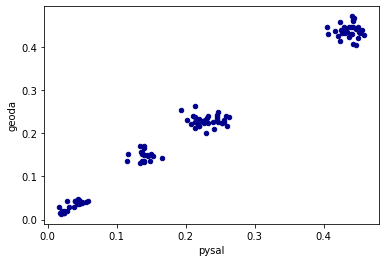

In [33]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results.p_sim, GeoDa_LJC.PP_VAL).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

# Next steps

- Ensure docstrings include all relevant information and formatting


# Setting up tests


In [1]:
import unittest
import numpy as np
from libpysal.weights.util import lat2W
from libpysal.common import pandas

PANDAS_EXTINCT = pandas is None

In [14]:
class Local_Join_Counts_Tester(unittest.TestCase):
    """Unit test for Local Join Counts (univariate)"""
    def setUp(self):
        self.w = lat2W(4, 4)
        self.y = np.ones(16)
        self.y[0:8] = 0

    def test_Local_Join_Counts(self):
            """Test method"""
            np.random.seed(12345)
            ljc = Local_Join_Count(connectivity=self.w).fit(self.y)
            assert np.array_equal(ljc.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2])

SyntaxError: invalid syntax (<ipython-input-14-36464d13931f>, line 12)

In [10]:
w = lat2W(4, 4)
y = np.ones(16)
y[0:8] = 0
np.random.seed(12345)
ljc = Local_Join_Count(connectivity=w).fit(y)
assertAlmostEqual(ljc.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2])

NameError: name 'assertAlmostEqual' is not defined

In [13]:
assert np.array_equal(ljc.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2])

In [36]:
# Why not use np.testing?
# With correct values, no message returned...
np.testing.assert_almost_equal(toy_results.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2])
# When we change the first value to an incorrect value, it throws an error...but this doesn't seem to happen above?
np.testing.assert_almost_equal(toy_results.LJC, [3, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2])

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 1 / 16 (6.25%)
Max absolute difference: 3.
Max relative difference: 1.
 x: array([0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2], dtype=uint64)
 y: array([3, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2])